<a href="https://colab.research.google.com/github/suasuasuasuasua/CSCI470-Spaceship-Titanic/blob/main/Spaceship_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install packages
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install tensorflow


In [22]:
# Imports
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt


In [23]:
############## Magic Constants ################
# Filename settings
FILE_PREFIX = "./data/"
train_filename = FILE_PREFIX + "train.csv"
test_filename = FILE_PREFIX + "test.csv"

# Scrap me: test.csv doesn't include the transported column! Should always be false
# Set to False if we want to only train and test on the train csv
loadSeparateTestCsv = False

# Set to true when we want to generate a submission for kaggle
testSubmission = False

# Common utility functions
def checkNotSubmitting():
    assert not testSubmission, "Don't run this cell if creating a submission"
################################################

In [24]:

# We might want to mount a shared google drive so we don't have to reupload
# everytime the session expires
trainData = pd.read_csv(train_filename)
data = None
testData = None
if loadSeparateTestCsv:
    testData = pd.read_csv(test_filename)
    data = pd.concat([trainData, testData])
else:
    data = trainData

if testSubmission:
    data = pd.read_csv(test_filename)

# FEATURE MODIFICATION SETTINGS
dropCols = ["PassengerId", "Name"]  # Columns to drop entirely
# Binary columns to replace with 1's and 0's
binaryCols = ["CryoSleep", "VIP", "Transported"]
# Category columns that are commonly shared, dummies are built from these
categoricalCols = []
# Ok my idea for this is that for the fairly unique columns we should generate a numerical
# id for each unique entry, then replace the column with the id. Generating dummies with these
# just leads to a feature explosion.
uniqueGeneratorCols = ["Cabin", "HomePlanet", "Destination"]
###############################

# Not sure why these features have NaN's, but we can (safely?) replace them with 0's.
data["CryoSleep"] = data["CryoSleep"].fillna(value=False)
data["VIP"] = data["VIP"].fillna(value=False)
data["VRDeck"] = data["VRDeck"].fillna(value=0)
data["ShoppingMall"] = data["ShoppingMall"].fillna(value=0)
data["RoomService"] = data["RoomService"].fillna(value=0)
data["FoodCourt"] = data["FoodCourt"].fillna(value=0)
data["Spa"] = data["Spa"].fillna(value=0)
# weird ones
data["Cabin"] = data["Cabin"].fillna(value="UNKNOWN")
data["HomePlanet"] = data["HomePlanet"].fillna(value="UNKNOWN")
data["Destination"] = data["Destination"].fillna(value="UNKNOWN")
data["Age"] = data["Age"].fillna(value=-1)

# test.csv doesn't have the transported column
if testSubmission and "Transported" in binaryCols:
    binaryCols.remove("Transported")
# We want to keep the passengerIds for submission
if testSubmission and "PassengerId" in dropCols:
    dropCols.remove("PassengerId")

data = data.drop(columns=dropCols)
for c in binaryCols:
    data[c] = data[c].astype(int)
data = pd.get_dummies(data, columns=categoricalCols)
# Generate unique ids per column
for c in uniqueGeneratorCols:
    data[c] = data[c].astype("category").cat.rename_categories(
        range(data[c].nunique()))

# We don't want any nan data
assert (not data.isnull().values.any())

yCol = "Transported"
X, y = None, None
if not testSubmission:
    X = data.drop(columns=yCol)
    y = data[yCol]
else:
    X = data

X_train, X_test, y_train, y_test = None, None, None, None
if not testSubmission:
    if testData is None:
        X_train, X_test, y_train, y_test = train_test_split(X, y)
    else:
        X_train = X[: trainData.shape[0]]
        X_test = X[trainData.shape[0]:]
        y_train = y[: trainData.shape[0]]
        y_test = y[trainData.shape[0]:]
else:
    X_test = X

# print(data.head())
# print(data.describe())


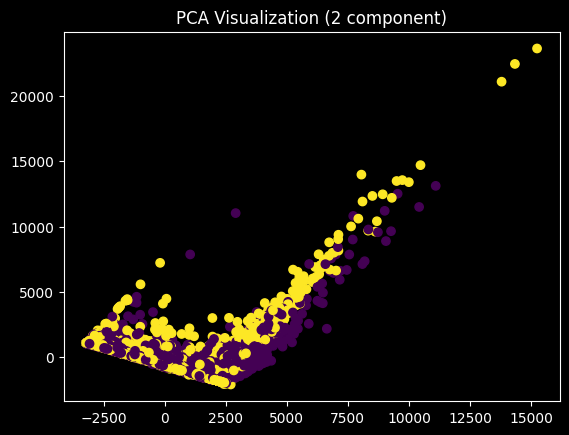

In [25]:
# Data visualization
# tSNE or PCA here

checkNotSubmitting()

pcaComps = 2
pca = PCA(n_components=pcaComps)
pca_train = pca.fit_transform(X_train, y_train)
pca_test = pca.transform(X_test)

if pcaComps == 2:
    plt.scatter(pca_train[:, 0], pca_train[:, 1], c=y_train)
plt.title(f"PCA Visualization ({pcaComps} component)")
plt.show()

# Feature importance graphing
# todo
estimators = 100  # todo: grid search me!
#gbc = GradientBoostingClassifier(n_estimators=100)
#gbc.fit(X_train, y_train)
# todo: render the important features
# look at my roommates code here: https://github.com/justincdavis/BowlGamesNN/blob/main/CFBowlGamesNN.ipynb


In [75]:
# Feature selection

checkNotSubmitting()

# can try filter, wrapper, and embedded methods: https://elearning.mines.edu/courses/40460/pages/instructional-learning-materials-feature-selection?module_item_id=529456
# todo...

### Notes ###
# Justin: I am super referencing homework 4A Feature Selection here
#         Not sure if everything will be fine as is, but we'll see
# TODO Make it better...
#      We can try different constants and metrics and models

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression


# Create a StandardScalar to standardize the passenger features
scalar = sk.preprocessing.StandardScaler().fit(X=X_train)
# XT_train and XT_test are like X_train and X_test,
#  except that they are normalized.
# Just didn't want to change the original values
XT_train = scalar.transform(X=X_train)
XT_test = scalar.transform(X=X_test)

print(f"---------------------------------Mutual Information-------------------------------------")
# Select the best features based on mutual information score from the training data,
#  then transform XT_train and XT_test into the new subset of selected features

k = 4 # Change this if needed
mutual_information_transformer = sk.feature_selection.SelectKBest(
    score_func=sk.feature_selection.mutual_info_regression,
    k=k
).fit(X=XT_train, y=y_train)
MI_X_train = mutual_information_transformer.transform(X=XT_train)
MI_X_test = mutual_information_transformer.transform(X=XT_test)

# Print out the mutual informations
# TODO looks like this works, but I'm worried about using data.columns
for feature, importance in zip(data.columns, mutual_information_transformer.scores_):
    print(f"The MI score for {feature} is {importance}")

# Create a linear regression model to estimate
miEst = LinearRegression().fit(MI_X_train, y_train)
print(f"\nThe mean squared error when training on the MI selected features is {mean_squared_error(y_train, miEst.predict(MI_X_train))}.")
print(f"\tWhen testing on the test data, the mean squared error is {mean_squared_error(y_test, miEst.predict(MI_X_test))}")

print(f"---------------------------------Recursive Elimination----------------------------------")
# Use recursive feature elimination (RFE) object to determine the k features to select 
# from X_train using a step of 2
rfeEst = LinearRegression()

rfe_transformer = sk.feature_selection.RFE(estimator=rfeEst, step=2).fit(X=XT_train,y=y_train)
rfe_X_train = rfe_transformer.transform(X=XT_train)
rfe_X_test = rfe_transformer.transform(X=XT_test)

rfeEst = LinearRegression().fit(rfe_X_train, y_train)

print(f"The mean squared error when training on the RFE selected features is {mean_squared_error(y_train, rfeEst.predict(rfe_X_train))}.")
print(f"\tWhen testing on the test data, the mean squared error is {mean_squared_error(y_test, rfeEst.predict(rfe_X_test))}")

# TODO: Did some weird indexing into data for columns 0-10 (11 columns)
#       The last column (transported) shouldn't be here? Idk.
print(f"The most important features as determined by RFE were {list(data.columns[:11][rfe_transformer.support_])}")


print(f"---------------------------------Lasso Embedded Method----------------------------------")
lassoEst = sk.linear_model.LassoCV(n_alphas=10).fit(X=XT_train, y=y_train)
for feature, coef in zip(data.columns, lassoEst.coef_):
    print(f"The magniture of the feature coefficient for {feature} is {abs(coef)}.")

print(f"The mean squared error when training using lasso is {mean_squared_error(y_train, lassoEst.predict(XT_train))}.")
print(f"\tWhen testing on the test data, the mean squared error is {mean_squared_error(y_test, lassoEst.predict(XT_test))}")

---------------------------------Mutual Information-------------------------------------
The MI score for HomePlanet is 0.005105602160949907
The MI score for CryoSleep is 0.10408860633004036
The MI score for Cabin is 0.0237268712484191
The MI score for Destination is 0.0121226337139273
The MI score for Age is 0.011716287407191217
The MI score for VIP is 0.0
The MI score for RoomService is 0.07234521718464038
The MI score for FoodCourt is 0.05060054334295305
The MI score for ShoppingMall is 0.04234140586491364
The MI score for Spa is 0.08162007599548549
The MI score for VRDeck is 0.06455077671056664

The mean squared error when training on the MI selected features is 0.18440926189041354.
	When testing on the test data, the mean squared error is 0.18632025679869305
---------------------------------Recursive Elimination----------------------------------
The mean squared error when training on the RFE selected features is 0.1757945808966095.
	When testing on the test data, the mean squared

In [ ]:
# Feature extraction

checkNotSubmitting()

# we don't want to use tSNE, consider spectral embedding? maybe linear discriminant analysis?
# todo...


In [ ]:
# Now we have the reduced dataset with high mutual information between each feature, time to run some models


In [ ]:
# knn or svm?

checkNotSubmitting()


In [ ]:
# Neural network

# Model parameters
activation = "sigmoid"
outputActivation = "sigmoid"  # This should not change
hiddenExpansionSize = 50
denseHiddenLayers = 3
autoencoderCompressionSize = 6
##################

# Andrew's model arch notes:
# - do we progressively collapse when autoencoding or dense map straight to it?
# - mess around with dropout layers to reduce overfitting

checkNotSubmitting()

layers = []
layers.append(tf.keras.layers.Dense(hiddenExpansionSize, input_shape=(
    X.shape[1],), activation=activation, name=f"input_{X.shape[1]}x1"))
for i in range(denseHiddenLayers):
    layers.append(tf.keras.layers.Dense(hiddenExpansionSize,
                  activation=activation, name=f"dense_{i}"))
layers.append(tf.keras.layers.Dense(autoencoderCompressionSize,
              activation=activation, name="autoenc"))
layers.append(tf.keras.layers.Dense(
    2, activation=outputActivation, name="output"))

dnn = tf.keras.Sequential(layers)
dnn.build()
dnn.summary()

nnDefaultWeights = dnn.get_weights()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11x1 (Dense)          (None, 50)                600       
                                                                 
 dense_0 (Dense)             (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 autoenc (Dense)             (None, 6)                 306       
                                                                 
 output (Dense)              (None, 2)                 14        
                                                                 
Total params: 8,570
Trainable params: 8,570
Non-trainabl

In [ ]:
# Neural network compilation and training

# TRAINING PARAMETERS
learningRate = 0.001
#lossFunc = "binary_crossentropy"
lossFunc = "mae"
epochs = 30
batchSize = 1000
#####################

if not testSubmission:
    optimizer = tf.keras.optimizers.Adam(learning_rate=learningRate)
    #optimizer = tf.keras.optimizers.SGD()

    dnn.compile(optimizer, loss=lossFunc, metrics=["accuracy"])

    dnn.set_weights(nnDefaultWeights)  # Reset if we already fit
    dnn.fit(X_train, y_train, batch_size=batchSize, epochs=epochs)

    nnMetrics = dnn.evaluate(X_test, y_test)
    print(f"NN evaluated accuracy: {nnMetrics}")
else:
    predictions = dnn.predict(X_test.drop(
        columns=["PassengerId"]), batch_size=batchSize)
    # We have 2 output nodes, we want to take the index of the node with greater activation
    predictionsBinary = np.argmax(predictions, axis=1)
    predictionsBinary = 1 - predictionsBinary  # Invert the result
    outData = pd.DataFrame()
    outData["PassengerId"] = X_test["PassengerId"]
    outData["Transported"] = predictionsBinary.astype(bool)
    outData.to_csv("results.csv", index=False)
